# Var and CVar

이번 강의에서는 리스크 관리에서 쓰이는 개념 중 하나인 Var(Value at risk)와 CVAR(Conditional Var)를 익히고, 여러 가지 방법을 통해 계산합니다.

## Var과 CVar의 정의

Var은 목표 보유기간 동안 일정한 신뢰수준에서 발생 가능한 최대손실금액을 통계적으로 표현한 수치입니다.<br>
그리고 CVar은 Var의 보조지표 중 하나로, 손실이 일정한 신뢰수준에서 발생 가능한 최대손실금액을 넘었을 경우의 기대손실입니다.<br>
즉 95% 신뢰수준의 1일 VaR가 10억원이라고 한다면, 하위 5% 성과의 커트라인이 -10억원이라는 것이고, 1일 CVar가 20억원이라고 한다면, 하위 5% 성과라는 조건하의 수익의 조건부기댓값이 -20억원이라는 것입니다.<br>
이를 수학적으로 표현하면, 손익 $x$의 확률분포함수를 $f(x)$라고 할 때,
$$Var =  -c \in \mathbb{R} : \displaystyle \int_{-\infty} ^c f(x)dx = \alpha $$
이 때, $\alpha$는 신뢰수준입니다.
$$CVar =   -\displaystyle \int_{-\infty} ^c xf(x)dx \$$
이때 마이너스를 붙이는 이유는 Var과 CVar가 손실의 절댓값이기 때문입니다.

## One Asset Var, CVar

우선 포트폴리오에 한 가지 자산만을 가지고 있다고 가정하고 Var과 CVar를 계산하겠습니다.

### 1-1. Delta - Normal Method

델타 노말 방법은 Var 계산 방법중 부분가치평가법에 해당하는 방법으로, 수익률이 정규분포를 이루고 있다고 가정하고 Var을 계산하는 방법입니다.
<br>
즉 위의 식에서, $f(x)$가 정규분포의 확률분포함수가 됩니다.<br>
95% 신뢰수준의 Var를 구하기 위해 정규분포에서 확률표본이 평균 - 1.65 * 표준편차 보다 낮을 확률이 5%인 것을 이용합니다. <br>
현재가가 $S_0$, 수익률의 기댓값이 $\mu$, 수익률의 표준편차가 $\sigma$ 일 때, 95% 신뢰수준의 Var는 다음과 같이 계산됩니다. <br>
하위 5% 수익률 = $1+\mu-1.65*\sigma$ <br>
95% 신뢰수준의 Var = 현재 잔고 - 하위 5% 잔고 = $S_0 - S_0(1+\mu-1.65*\sigma)$ = $S_0(1.65*\sigma-\mu)$<br>
이때 신뢰수준이 99%이면 1.65 대신 2.33을, 99.9%이면 1.65 대신 3.08을 대입하면 됩니다.<br>
이제 실제 데이터를 기반으로 Var를 계산하겠습니다.<br>
현재 잔고는 1억원이며, 이 자금을 모두 S&P 500 지수를 정확히 추종하는 펀드에 투자한다고 가정합니다. <br>
1일 기대 수익률은 지난 1년간의 1일 수익률의 평균으로, 표준편차는 30일 수익률의 표준편차를 이용하여 계산합니다.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy

In [2]:
df0 = yf.download(["^SPX"])

[*********************100%%**********************]  1 of 1 completed


In [3]:
df0["return"] = df0["Close"].pct_change()

우리가 사용할 데이터는 1년 전부터의 데이터입니다.

In [4]:
df = df0.iloc[-252:]
mu = np.mean(df["return"])
sigma = np.std(df["return"])

수익률의 분포는 다음과 같습니다. $r \sim N(\mu,\sigma^2)$ <br>
즉 수익률의 확률분포함수는 다음과 같은 형태를 그립니다.

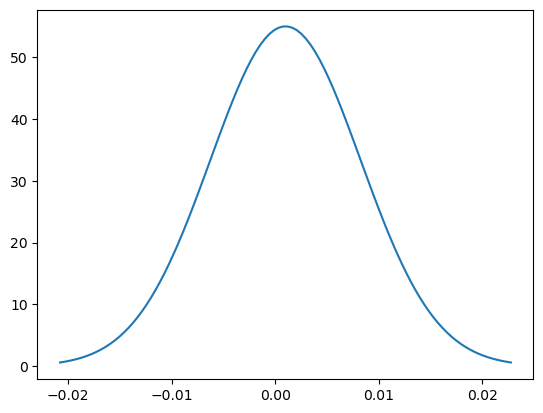

In [5]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

그리고 다음날의 잔고는 다음과 같은 분포를 따릅니다.
$$B = S_0(1+r) \sim N(S_0(1+\mu), S_0^2\sigma^2)$$
이를 이용하여 Var를 구할 수 있습니다.

In [6]:
s0 = 100000000
normalVar = s0-s0*(1+mu-1.65*sigma)
print(normalVar)

1097957.4054082185


즉, S&P500 지수추종펀드에 1억원을 투자했을 때 95% 신뢰수준의 1일 Var는 110만원입니다.<br>
그리고 다음날 잔고의 확률분포함수는 다음과 같은 모양을 가집니다.

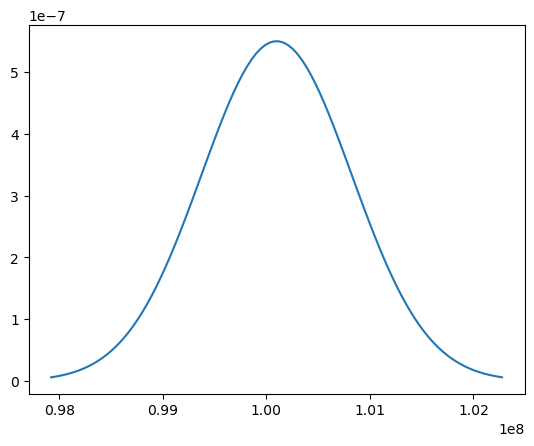

In [7]:
plt.plot(s0*(1+x), stats.norm.pdf(s0*(1+x), s0*(1+mu), s0*sigma))

이 확률분포함수를 $f(x)$라 할 때,  $-\infty$부터 현재 잔고에서 Var을 차감한 금액인 7168만원까지 $xf(x)$를 적분하고, 조건부기댓값이니 적분값에 (1-신뢰수준)의 역수를 곱한 뒤,이를 원금에서 빼면 CVar가 나옵니다.

In [8]:
s0-scipy.integrate.quad(lambda x: stats.norm.pdf(x,loc=s0*(1+mu),scale = s0*sigma)*x, 0,s0-1097957)[0]*20

2442752.4979421794

즉 S&P500 지수추종펀드에 1억원을 투자했을 때 95% 신뢰수준의 1일 CVar는 244만원입니다.

### 1-2 Historical Simulation

역사적 시뮬레이션 방법은 시장변수의 과거자료를 이용해서 하위 95% 수익률을 구하는 방법입니다.
우선 과거 모든 날의 S&P 500의 수익률을 계산한 뒤, 오름차순으로 정렬합니다.

In [9]:
dfh = df0.sort_values(by=['return'])
dfh

,Open,High,Low,Close,Adj Close,Volume,return
Date,,,,,,,
1987-10-19,282.700012,282.700012,224.830002,224.839996,224.839996,604300000,-0.204669
1929-10-28,22.740000,22.740000,22.740000,22.740000,22.740000,0,-0.129403
2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7805450000,-0.119841
1929-10-29,20.430000,20.430000,20.430000,20.430000,20.430000,0,-0.101583
1935-04-16,8.220000,8.220000,8.220000,8.220000,8.220000,0,-0.099671
...,...,...,...,...,...,...,...
1939-09-05,12.640000,12.640000,12.640000,12.640000,12.640000,0,0.118584
1931-10-06,9.910000,9.910000,9.910000,9.910000,9.910000,0,0.123583
1929-10-30,22.990000,22.990000,22.990000,22.990000,22.990000,0,0.125306


총 24211개의 데이터가 있으니 이 중 하위 5%는 1210개입니다. 즉 뒤에서 1210등의 수익률을 찾으면 그것이 Var입니다.

In [10]:
dfh.iloc[1210]["return"]

-0.016841443188383765

즉 1.68% 손실이 날 때가 하위 5% 성과이며, Var는 $0.0168S_0$인 168만원입니다.
CVar는 하위 5%이하 수익률을 평균을 내서 구할 수 있습니다.

In [11]:
dfh.iloc[0:1211]["return"].mean()

-0.028559355509769666

즉 CVAR은 $0.0286S_0$인 286만원입니다.

### 1-3 Monte Carlo Simulation

파생상품 가격 결정을 위해 사용했던 몬테카를로 시뮬레이션을 Var 측정에도 사용할 수 있습니다.<br>
평균과 표준편차를 가지고 가상의 주가패스를 제작해, 하위 5% 성과와 기댓값을 이용해 Var과 CVar를 구할 수 있습니다.

In [12]:
Normal = np.random.normal(size=(1, 10000))
path = np.zeros((2,10000))
path[0] = s0
logds = mu + Normal * sigma

path[1] = path[0]*(1+logds[0])

10000번의 시뮬레이션을 시행했으니 뒤에서 500등의 손실액을 구하면 Var를 구할 수 있습니다

In [13]:
100000000-np.sort(path[1])[499]

1120959.9294766635

즉 Var는 112만원 입니다. CVar는 뒤에서 500등까지의 손실액의 평균으로 구합니다.

In [14]:
100000000-np.mean(np.sort(path[1])[0:500])

1404022.3088208735

즉 CVar는 140만원입니다.

## 2. Two Asset Var, Cvar

### 2-1 Delta Normal Method

이제 포트폴리오에 두 가지 자산이 있을 경우의 Var과 CVar를 계산해 보겠습니다. <br>
Var는 가법성이 없기 때문에, 두 자산이 있을 경우에는 포트폴리오의 분포를 다시 구해야 합니다. <br>
Var를 구하기 위해 다음 규칙을 이용합니다.<br>
If $ X\sim N(\mu_x, \sigma_x^2)$ and $Y \sim N(\mu_y, \sigma_y^2)$
$$aX+bY \sim N(a\mu_x+b\mu_y, a^2\sigma_x^2+b^2\sigma_y^2+2abcov(X,Y))$$
이제 투자자가 S&P 500을 추종하는 펀드와 Nikkei 225를 추종하는 펀드에 각각 자금의 절반씩 투자한다고 가정합니다.
이 가정 하에 위에서 시행한 내용을 반복합니다.

In [15]:
df2 = yf.download(["^SPX", "^N225"])["Close"]

[*********************100%%**********************]  2 of 2 completed


In [16]:
df2["return1"] = df2["^N225"].pct_change()
df2["return2"] = df2["^SPX"].pct_change()
df2 = df2.dropna()

In [17]:
df3 = df2.iloc[-252:]

In [18]:
mu1 = np.mean(df3["return1"])
mu2 = np.mean(df3["return2"])
sigma1 = np.std(df3["return1"])
sigma2 = np.std(df3["return2"])
cov = np.cov(df3["return1"],df3["return2"])[0,1]

In [19]:
mup = 0.5*mu1+0.5*mu2
sigmap = np.sqrt(0.25*sigma1**2+0.25*sigma2**2+2*0.5*0.5*cov)

포트폴리오의 1일 수익률의 분포는 다음과 같습니다

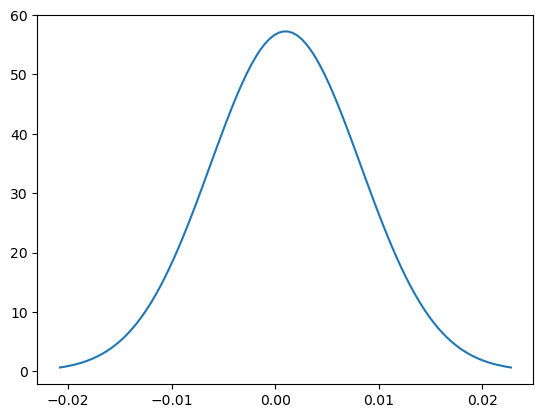

In [20]:
x1 = np.linspace(mup - 3*sigmap, mup + 3*sigmap, 100)
plt.plot(x, stats.norm.pdf(x1, mup, sigmap))
plt.show()

In [21]:
normalVarp = s0-s0*(1+mup-1.65*sigmap)
print(normalVarp)

1049651.2722752243


즉 S&P 500 지수추종 펀드와 Nikkei 225 지수추종 펀드에 각각 반씩 투자했을 때의 95% 신뢰수준 하에서 1일 Var는 105만원입니다.

In [22]:
s0-scipy.integrate.quad(lambda x: stats.norm.pdf(x,loc=s0*(1+mup),scale = s0*sigmap)*x, 0,s0-1049651)[0]*20

2383123.9930104613

CVar는 238만원입니다.

### 2-2 Historical Simulation

과거 데이터를 이용하여 S&P 500과 Nikkei 225에 반씩 투자했을 때의 수익률을 구합니다.

In [23]:
df2["returnp"] = (df2["return1"]+df2["return2"])/2

In [24]:
dfh2 = df2.sort_values(by=['returnp'])
dfh2

,^N225,^SPX,return1,return2,returnp
Date,,,,,
1987-10-19,25746.560547,224.839996,-0.023521,-0.204669,-0.114095
2020-03-16,17002.039062,2386.129883,-0.024612,-0.119841,-0.072226
2020-03-12,18559.630859,2480.639893,-0.044109,-0.095113,-0.069611
2008-11-20,7703.040039,752.440002,-0.068919,-0.067123,-0.068021
2008-10-24,7649.080078,876.770020,-0.095958,-0.034511,-0.065235
...,...,...,...,...,...
1990-10-02,22898.410156,315.209991,0.132359,0.000857,0.066608
2008-10-14,9447.570312,998.010010,0.141503,-0.005322,0.068090
2020-03-24,18092.349609,2447.330078,0.071328,0.093828,0.082578


데이터의 개수가 총 14115개이니, 하위 5%의 커트라인은 뒤에서 706번째 수익률입니다.

In [25]:
100000000*(-dfh2["returnp"][706])

1312672.3647804428

즉 Var는 131만원입니다.

In [26]:
100000000*(-dfh2.iloc[0:707]["returnp"].mean())

2027727.0627280409

즉 CVar는 203만원입니다.

### 2-3 Monte Carlo Simulation

이전에 사용한 기초자산이 두 개일 때의 파생상품의 가격 결정 때 사용했던 방법을 이용합니다.<br>
일단 두 자산의 수익률 간의 상관계수를 계산합니다.

In [27]:
rho = np.corrcoef(df3["return1"],df3["return2"])[0,1]

In [28]:
Normal1 = np.random.normal(size=(1, 10000))
Normal2 = np.random.normal(size=(1, 10000))
Normal2= rho*Normal1 + np.sqrt(1-rho**2)*Normal2

In [29]:
logds1 = mu1 + Normal1 * sigma1
logds2 = mu2 + Normal2 * sigma2

각 자산에 5000만원 씩 투자하는 것을 적용합니다.

In [30]:
path1 = np.zeros((2,10000))
path2 = np.zeros((2,10000))
path1[0] = s0/2
path2[0] = s0/2
path1[1] = path1[0]*(1+logds1[0])
path2[1] = path2[0]*(1+logds2[0])

포트폴리오의 가치는 두 자산의 가치를 더하는 것으로 계산할 수 있습니다.

In [31]:
pathp = path1+path2

이제 Var과 CVar를 구할 수 있습니다

In [32]:
100000000-np.sort(pathp[1])[499]

1026207.1130867004

In [33]:
100000000-np.mean(np.sort(pathp[1])[0:500])

1320216.878937319

Var는 102만원, CVar는 132만원으로 계산됩니다.